# Create and Visualize Forecasts

In [61]:
%reload_ext autoreload
%autoreload 2

import torch
import datetime
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta

from rnn import LSTM
from forecast import forecast_pipeline
from utils import format_yahoo_datetimes

In [62]:
symbols = ['AMZN']      # stocks to make predictions for
device = 'cuda:0'       # device to use; cuda or cpu
steps = 10              # future time steps to predict for

In [63]:
# Load model
kwargs, state = torch.load('models/rnn/weights/best.pth', map_location=torch.device(device))
model = LSTM(**kwargs)
model.load_state_dict(state)
model.to(device)
model.eval()

# List to store predictions
outputs = []

# Create predictions for each stock
for _, stock in enumerate(symbols):
    stock = stock.replace('.', '-')   # format ticker symbol

    predictions = torch.rand(1,0,5)   # tensor to store future predictions

    # Send empty tensor to device
    if 'cuda' in device:
        predictions = predictions.cuda()

    # Format datetimes to download most recent daat from Yahoo Finance
    now = dt.datetime.now()
    a = dt.datetime(1970,1,1,23,59,59)
    b = dt.datetime(now.year, now.month, now.day, 23, 59, 59)
    c = b - relativedelta(years=5)

    period1 = str(int((c-a).total_seconds()))   # total seconds from today since Jan. 1, 1970 subracting 5 years
    period2 = str(int((b-a).total_seconds()))   # total seconds from today since Jan. 1, 1970

    period1, period2 = format_yahoo_datetimes()

    # Download data
    data = pd.read_csv('https://query1.finance.yahoo.com/v7/finance/download/{x}?period1={period1}&period2={period2}&interval=1d&events=history&includeAdjustedClose=true'.format(x=stock, period1=period1,period2=period2))
    data = data[['Date', 'Open', 'High', 'Low', 'Volume', 'Close']]

    forecast = forecast_pipeline(data, model, steps, device)

    outputs.append(pd.concat([data, forecast], ignore_index=True))

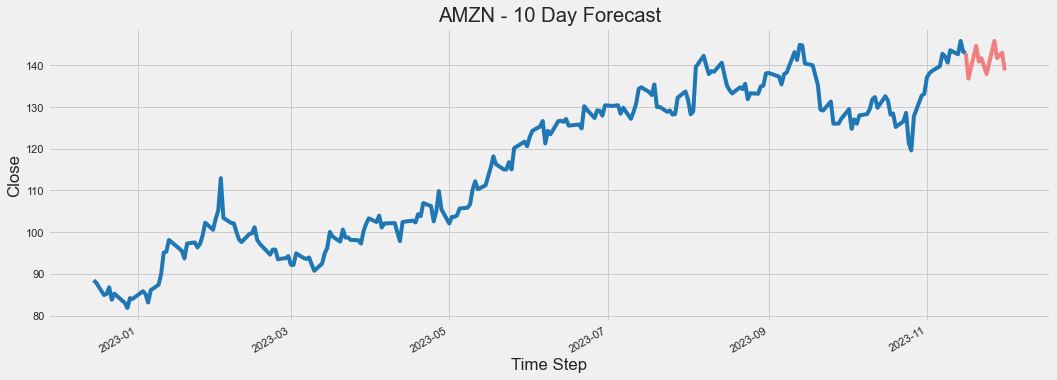

In [67]:
%matplotlib inline
sns.set()
plt.style.use('fivethirtyeight')

# Plot each stock
for i, x in enumerate(outputs):
    plt.figure(figsize=(16, 6))
    plt.title(f"{symbols[i]} - {steps} Day Forecast")
    plt.gcf().autofmt_xdate()
    plt.ylabel("Close")
    plt.xlabel("Time Step")
    plt.plot(x.loc[(len(x.index)-252+steps):(len(x.index)-steps-1), "Date"], x.loc[(len(x.index)-252+steps):(len(x.index)-steps-1), "Close"], color='tab:blue')
    plt.plot(x.loc[(len(x.index)-steps-1):,"Date"], x.loc[(len(x.index)-steps-1):,"Close"], color='lightcoral')
    plt.show()